# TradAD: применение трансформерных состязательных сетей для временных рядов ЭЭГ
### ФИО: Никишкина Евгения Геннадьевна

In [1]:
!pip install torch==1.12.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 MB 1.6 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: torch
    Found existing installation: torch 2.0.0
    Uninstalling torch-2.0.0:
      Successfully uninstalled torch-2.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchdata 0.6.0 requires torch==2.0.0, but you have torch 1.12.1 which is incompatible.


In [5]:
import torch
import torch.nn as nn
from torch.nn import TransformerEncoder
from torch.nn import TransformerDecoder
import numpy as np
import os
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import torch.nn.functional as F
import seaborn as sns

# 0. Constants

In [6]:
DIMS = 62
WINDOW = 10
LR = 0.001
BATCH_SIZE = 128
QUANTILE = 0.001

## 1. Modeling 

In [7]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model).float() * (-math.log(10000.0) / d_model))
        pe += torch.sin(position * div_term)
        pe += torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x, pos=0):
        x = x + self.pe[pos:pos+x.size(0), :]
        return self.dropout(x)

class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=16, dropout=0):
        super(TransformerEncoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

        self.activation = nn.LeakyReLU(True)

    def forward(self, src,src_mask=None, src_key_padding_mask=None):
        src2 = self.self_attn(src, src, src)[0]
        src = src + self.dropout1(src2)
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout2(src2)
        return src

class TransformerDecoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=16, dropout=0):
        super(TransformerDecoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.multihead_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

        self.activation = nn.LeakyReLU(True)

    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None):
        tgt2 = self.self_attn(tgt, tgt, tgt)[0]
        tgt = tgt + self.dropout1(tgt2)
        tgt2 = self.multihead_attn(tgt, memory, memory)[0]
        tgt = tgt + self.dropout2(tgt2)
        tgt2 = self.linear2(self.dropout(self.activation(self.linear1(tgt))))
        tgt = tgt + self.dropout3(tgt2)
        return tgt
    
class TranAD(nn.Module):
    def __init__(self, feats):
        super(TranAD, self).__init__()
        self.name = 'TranAD'
        self.lr = LR
        self.batch = BATCH_SIZE
        self.n_feats = feats
        self.n_window = WINDOW
        self.n = self.n_feats * self.n_window
        self.pos_encoder = PositionalEncoding(2 * feats, 0.1, self.n_window)
        encoder_layers = TransformerEncoderLayer(d_model=2 * feats, nhead=feats, dim_feedforward=16, dropout=0.1)
        self.transformer_encoder = TransformerEncoder(encoder_layers, 1)
        decoder_layers1 = TransformerDecoderLayer(d_model=2 * feats, nhead=feats, dim_feedforward=16, dropout=0.1)
        self.transformer_decoder1 = TransformerDecoder(decoder_layers1, 1)
        decoder_layers2 = TransformerDecoderLayer(d_model=2 * feats, nhead=feats, dim_feedforward=16, dropout=0.1)
        self.transformer_decoder2 = TransformerDecoder(decoder_layers2, 1)
        self.fcn = nn.Sequential(nn.Linear(2 * feats, feats), nn.Sigmoid())

    def encode(self, src, c, tgt):
        src = torch.cat((src, c), dim=2)
        src = src * math.sqrt(self.n_feats)
        src = self.pos_encoder(src)
        memory = self.transformer_encoder(src)
        tgt = tgt.repeat(1, 1, 2)
        return tgt, memory

    def forward(self, src, tgt):
        # Phase 1 - Without anomaly scores
        c = torch.zeros_like(src)
        x1 = self.fcn(self.transformer_decoder1(*self.encode(src, c, tgt)))
        # Phase 2 - With anomaly scores
        c = (x1 - src) ** 2
        x2 = self.fcn(self.transformer_decoder2(*self.encode(src, c, tgt)))
        return x1, x2

## 2. Varka

In [8]:
def convert_to_windows(data):
    windows = []
    w_size = WINDOW
    for i, g in enumerate(data):
        if i >= w_size: 
            w = data[i-w_size:i]
        else: 
            w = torch.cat([data[0].repeat(w_size-i, 1), data[0:i]])
        windows.append(w)
    return torch.stack(windows)

In [42]:
mn = torch.full((DIMS,), 1e9)
mx = torch.full((DIMS,), -1e9)
r_path = '/kaggle/input/seed-1-tr/seed_iv/train'
paths = sorted(os.listdir(r_path))

for name in paths[:8]:
    cur_tensor = torch.DoubleTensor(np.load(os.path.join(r_path, name)).T)
    cur_tensor[(cur_tensor > torch.quantile(cur_tensor, 1 - QUANTILE, axis=0)) | (cur_tensor < torch.quantile(cur_tensor, QUANTILE, axis=0))] = 0
    mn = torch.minimum(mn, torch.min(cur_tensor, dim=0)[0])
    mx = torch.maximum(mx, torch.max(cur_tensor, dim=0)[0])

In [43]:
trainD = []
for name in paths[:8]:
    cur_tensor = torch.DoubleTensor(np.load(os.path.join(r_path, name)).T)
    cur_tensor[(cur_tensor > torch.quantile(cur_tensor, 1 - QUANTILE, axis=0)) | (cur_tensor < torch.quantile(cur_tensor, QUANTILE, axis=0))] = 0
    cur_tensor = (cur_tensor - mn) / (mx - mn)
    trainD.append(convert_to_windows(cur_tensor))
trainD = torch.concat(trainD, dim=0)
print('trainD size:', trainD.shape)


valD = []
for name in paths[8:]:
    cur_tensor = torch.DoubleTensor(np.load(os.path.join(r_path, name)).T)
    cur_tensor[(cur_tensor > torch.quantile(cur_tensor, 1 - QUANTILE, axis=0)) | (cur_tensor < torch.quantile(cur_tensor, QUANTILE, axis=0))] = 0
    cur_tensor = (cur_tensor - mn) / (mx - mn)
    valD.append(convert_to_windows(cur_tensor))
valD = torch.concat(valD, dim=0)
print('valD size:', valD.shape)

trainD size: torch.Size([347608, 10, 62])
valD size: torch.Size([94002, 10, 62])


In [44]:
r_path = '/kaggle/input/seed-1-tr/seed_iv/val/0'
paths = sorted(os.listdir(r_path))

test0 = []
for name in paths:
    cur_tensor = torch.DoubleTensor(np.load(os.path.join(r_path, name)).T)
    cur_tensor[(cur_tensor > torch.quantile(cur_tensor, 1 - QUANTILE, axis=0)) | (cur_tensor < torch.quantile(cur_tensor, QUANTILE, axis=0))] = 0
    cur_tensor = (cur_tensor - mn) / (mx - mn)
    test0.append(convert_to_windows(cur_tensor))
test0 = torch.concat(test0, dim=0)
print('test0 size:', test0.shape)

test0 size: torch.Size([220805, 10, 62])


In [45]:
r_path = '/kaggle/input/seed-1-tr/seed_iv/val/1'
paths = sorted(os.listdir(r_path))

test1 = []
for name in paths:
    cur_tensor = torch.DoubleTensor(np.load(os.path.join(r_path, name)).T)
    cur_tensor[(cur_tensor > torch.quantile(cur_tensor, 1 - QUANTILE, axis=0)) | (cur_tensor < torch.quantile(cur_tensor, QUANTILE, axis=0))] = 0
    cur_tensor = (cur_tensor - mn) / (mx - mn)
    test1.append(convert_to_windows(cur_tensor))
test1 = torch.concat(test1, dim=0)
print('test1 size:', test1.shape)

test1 size: torch.Size([234005, 10, 62])


In [46]:
r_path = '/kaggle/input/seed-1-tr/seed_iv/val/2'
paths = sorted(os.listdir(r_path))

test2 = []
for name in paths:
    cur_tensor = torch.DoubleTensor(np.load(os.path.join(r_path, name)).T)
    cur_tensor[(cur_tensor > torch.quantile(cur_tensor, 1 - QUANTILE, axis=0)) | (cur_tensor < torch.quantile(cur_tensor, QUANTILE, axis=0))] = 0
    cur_tensor = (cur_tensor - mn) / (mx - mn)
    test2.append(convert_to_windows(cur_tensor))
test2 = torch.concat(test2, dim=0)
print('test2 size:', test2.shape)

test2 size: torch.Size([224005, 10, 62])


In [47]:
train_dataset = torch.utils.data.TensorDataset(trainD, trainD)
train_dataloader =  torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=0, shuffle=False)

val_dataset = torch.utils.data.TensorDataset(valD, valD)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=0, shuffle=False)

test0_dataset = torch.utils.data.TensorDataset(test0, test0)
test0_dataloader = torch.utils.data.DataLoader(test0_dataset, batch_size=BATCH_SIZE, num_workers=0, shuffle=False)
test1_dataset = torch.utils.data.TensorDataset(test1, test1)
test1_dataloader = torch.utils.data.DataLoader(test1_dataset, batch_size=BATCH_SIZE, num_workers=0, shuffle=False)
test2_dataset = torch.utils.data.TensorDataset(test2, test2)
test2_dataloader = torch.utils.data.DataLoader(test2_dataset, batch_size=BATCH_SIZE, num_workers=0, shuffle=False)

## Baseline model

In [49]:
class EasyModel(torch.nn.Module):
    def __init__(self, channels, window_size):
        super().__init__()
        self.linear1 = torch.nn.Linear(channels * window_size, 1024)
        self.linear2 = torch.nn.Linear(1024, window_size)
    
    def forward(self, batch):
        return self.linear2(torch.nn.functional.relu(self.linear1(batch)))

emodel = EasyModel(9, 62).to('cuda')
optimizer = torch.optim.AdamW(emodel.parameters() , lr=1e-5, weight_decay=1e-5)

In [50]:
emodel.eval()
l = nn.MSELoss(reduction = 'none')
for epoch in range(1, 11):
    print(f'Epoch {epoch}')
    emodel.train()
    l = nn.MSELoss(reduction = 'none')
    l1s = []
    for d, _ in train_dataloader:
        optimizer.zero_grad()
        d = d.to('cuda', dtype=torch.float)
        x = d[:, :9, :].reshape(d.size(0), 9 * 62)
        y = d[:, 9, :]
        z = emodel(x)
        l1 = l(z, y)
        l1s.append(torch.mean(l1).item())
        loss = torch.mean(l1)
        
        loss.backward(retain_graph=True)
        optimizer.step()
    
    print(f'Train loss: {np.mean(l1s)}')

    with torch.no_grad():
        ls = []
        z1 = []
        for d, _ in val_dataloader:
            d = d.to('cuda', dtype=torch.float)
            x = d[:, :9, :].reshape(d.size(0), 9 * 62)
            y = d[:, 9, :]
            z = emodel(x)
            cur_l = l(z, y)
            ls.append(torch.mean(cur_l).item())
            z1.append(z)
        
    print(f'Val loss: {np.mean(ls)}')
    print()

Epoch 1
Train loss: 0.009642559159432218
Val loss: 0.004797070893636417

Epoch 2
Train loss: 0.0034526351239910795
Val loss: 0.003607797439425525

Epoch 3
Train loss: 0.002676819007244854
Val loss: 0.0029829810321216985

Epoch 4
Train loss: 0.0022132628838550873
Val loss: 0.002541243243284625

Epoch 5
Train loss: 0.0018865507740408404
Val loss: 0.0022109124937797994

Epoch 6
Train loss: 0.001641437772084343
Val loss: 0.0019378532052870055

Epoch 7
Train loss: 0.001448963836867764
Val loss: 0.0017250014943400156

Epoch 8
Train loss: 0.0012954058045804616
Val loss: 0.0015610695426149586

Epoch 9
Train loss: 0.0011716222212694802
Val loss: 0.0014264159901606135

Epoch 10
Train loss: 0.001070322976061448
Val loss: 0.0013121711818000847



In [51]:
with torch.no_grad():
    ls = []
    z1 = []
    l1 = []
    for d, _ in val_dataloader:
        d = d.to('cuda', dtype=torch.float)
        x = d[:, :9, :].reshape(d.size(0), 9 * 62)
        y = d[:, 9, :]
        z = emodel(x)
        cur_l = l(z, y)
        ls.append(torch.mean(cur_l).item())
        l1.append(cur_l[0])
        z1.append(z)
    
    l1, z1 = torch.concat(l1, dim=0), torch.concat(z1, dim=0)
loss = l1.detach().cpu().numpy()
y_pred = z1.detach().cpu().numpy()

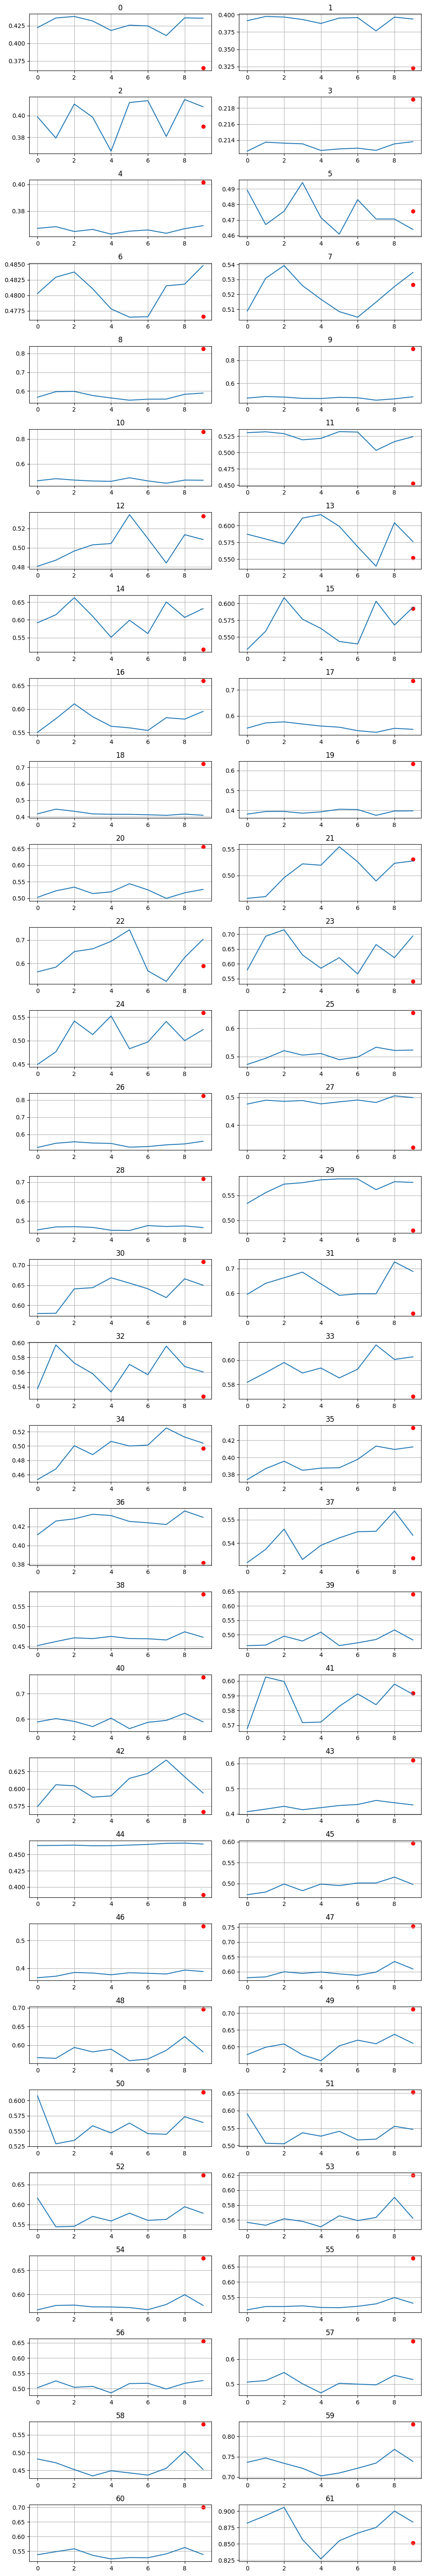

In [52]:
fig, ax = plt.subplots(31, 2, figsize=(10, 60))
for i in range(31):
    ax[i][0].plot(trainD[13, :, i * 2])
    ax[i][1].plot(trainD[13, :, i * 2 + 1])
    
    ax[i][0].scatter([9], [y_pred[13, i * 2]], c='r')
    ax[i][1].scatter([9], [y_pred[13, i * 2 + 1]], c='r')
    
    ax[i][0].grid()
    ax[i][1].grid()
    
    ax[i][0].set_title(str(i * 2))
    ax[i][1].set_title(str(i * 2 + 1))

fig.tight_layout()
fig.show()

## 3. Training

In [30]:
def train_epoch(epoch_step, dataloader, model, optimizer, scheduler, device):
    model.train()
    l = nn.MSELoss(reduction = 'none')
    l1s = []
    
    # epoch_step should be >= 1
    for d, _ in dataloader:
        optimizer.zero_grad()
        
        d = d.to(device)
        local_bs = d.shape[0]
        window = d.permute(1, 0, 2)
        elem = window[-1, :, :].view(1, local_bs, DIMS)
        z = model(window, elem)
        l1 = (1 / epoch_step) * l(z[0], elem) + (1 - 1/epoch_step) * l(z[1], elem)
        z = z[1]
        l1s.append(torch.mean(l1).item())
        loss = torch.mean(l1)
        
        loss.backward(retain_graph=True)
        optimizer.step()

    scheduler.step()
    print(f'Train loss: {np.mean(l1s)}')
    
def val_epoch(epoch_step, dataloader, model, device, flag=False):
    model.eval()
    l = nn.MSELoss(reduction = 'none')

    with torch.no_grad():
        ls = []
        l1 = []
        z1 = []
        for d, _ in dataloader:
            d = d.to(device)
            window = d.permute(1, 0, 2)
            elem = window[-1, :, :].view(1, -1, DIMS)
            z = model(window, elem)
            z = z[1]
            cur_l = l(z, elem)
            ls.append(torch.mean(cur_l).item())
            l1.append(cur_l[0])
            z1.append(z[0])
        
        if flag:
            print(f'Val loss: {np.mean(ls)}')
        return torch.concat(l1, dim=0), torch.concat(z1, dim=0)

In [55]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
model = TranAD(DIMS).double().to(device)
optimizer = torch.optim.AdamW(model.parameters() , lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 5, 0.9)

In [33]:
for epoch in range(1, 11):
    print(f'Epoch {epoch}')
    train_epoch(epoch, train_dataloader, model, optimizer, scheduler, device)
    val_epoch(epoch, train_dataloader, model, device)
    val_epoch(epoch, val_dataloader, model, device)
    print()

Epoch 1
Train loss: 0.0028129666897999334

Epoch 2
Train loss: 0.0016126335775926092

Epoch 3
Train loss: 0.0012273306373362769

Epoch 4
Train loss: 0.0010070433778826288

Epoch 5
Train loss: 0.0009210806735352072

Epoch 6
Train loss: 0.0008547179519082232

Epoch 7
Train loss: 0.0008437682577943588

Epoch 8
Train loss: 0.0008042859701693952

Epoch 9
Train loss: 0.0007933565069147759

Epoch 10
Train loss: 0.0007654996788211323



In [38]:
loss, y_pred = val_epoch(epoch, val_dataloader, model, device, True)

Val loss: 0.0010779641946261323


In [39]:
loss = loss.detach().cpu().numpy()
y_pred = y_pred.detach().cpu().numpy()

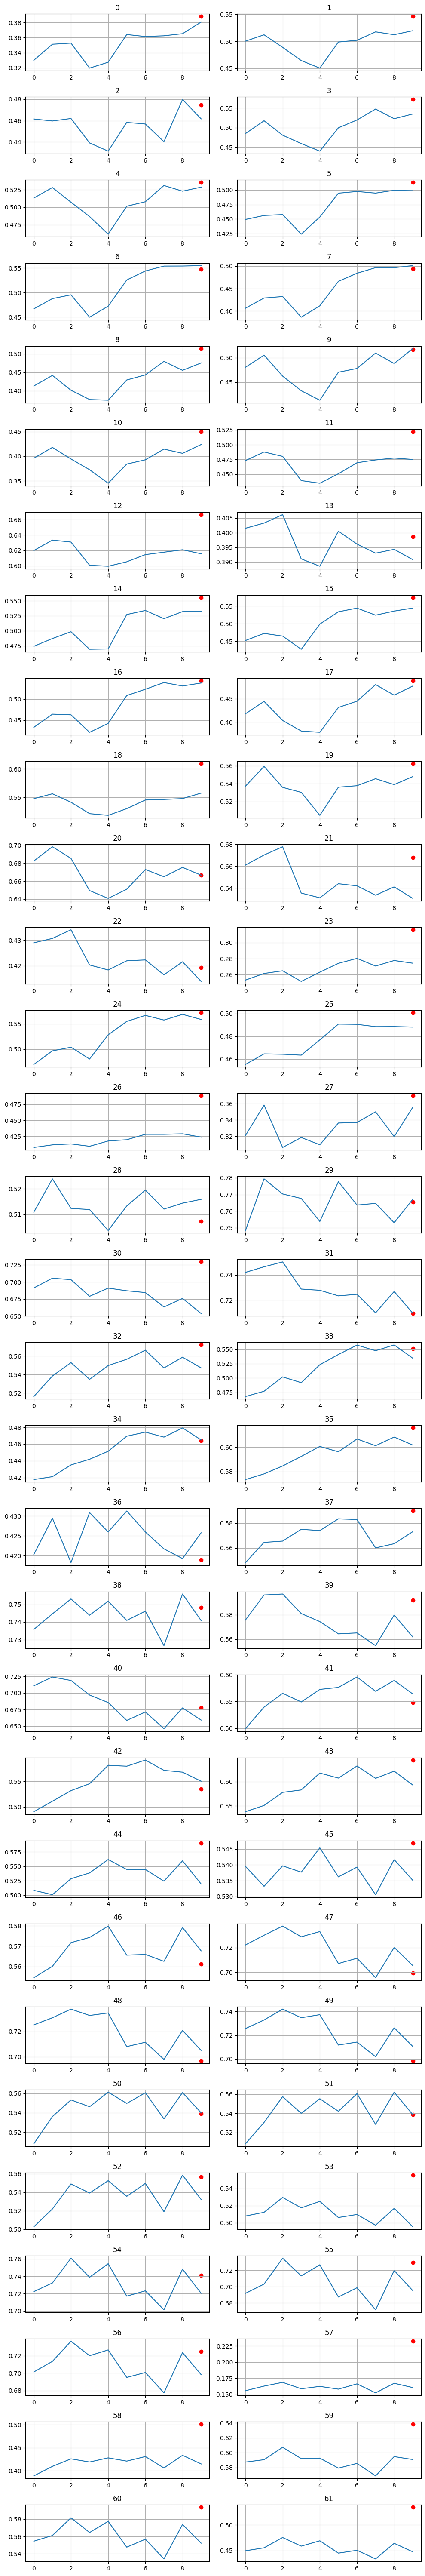

In [40]:
fig, ax = plt.subplots(31, 2, figsize=(10, 60))
for i in range(31):
    ax[i][0].plot(valD[10, :, i * 2])
    ax[i][1].plot(valD[10, :, i * 2 + 1])
    
    ax[i][0].scatter([9], [y_pred[10, i * 2]], c='r')
    ax[i][1].scatter([9], [y_pred[10, i * 2 + 1]], c='r')
    
    ax[i][0].grid()
    ax[i][1].grid()
    
    ax[i][0].set_title(str(i * 2))
    ax[i][1].set_title(str(i * 2 + 1))

fig.tight_layout()
fig.show()

## 4. POT

In [53]:
from math import log, floor

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm
from scipy.optimize import minimize

In [54]:
class SPOT:
    """
    This class allows to run SPOT algorithm on univariate dataset (upper-bound)
    
    Attributes
    ----------
    proba : float
        Detection level (risk), chosen by the user
        
    extreme_quantile : float
        current threshold (bound between normal and abnormal events)
        
    data : numpy.array
        stream
    
    init_data : numpy.array
        initial batch of observations (for the calibration/initialization step)
    
    init_threshold : float
        initial threshold computed during the calibration step
    
    peaks : numpy.array
        array of peaks (excesses above the initial threshold)
    
    n : int
        number of observed values
    
    Nt : int
        number of observed peaks
    """

    def __init__(self, q=1e-4):
        """
        Constructor

        Parameters
        ----------
        q
            Detection level (risk)
    
        Returns
        ----------
        SPOT object
        """
        self.proba = q
        self.extreme_quantile = None
        self.data = None
        self.init_data = None
        self.init_threshold = None
        self.peaks = None
        self.n = 0
        self.Nt = 0

    def __str__(self):
        s = ''
        s += 'Streaming Peaks-Over-Threshold Object\n'
        s += 'Detection level q = %s\n' % self.proba
        if self.data is not None:
            s += 'Data imported : Yes\n'
            s += '\t initialization  : %s values\n' % self.init_data.size
            s += '\t stream : %s values\n' % self.data.size
        else:
            s += 'Data imported : No\n'
            return s

        if self.n == 0:
            s += 'Algorithm initialized : No\n'
        else:
            s += 'Algorithm initialized : Yes\n'
            s += '\t initial threshold : %s\n' % self.init_threshold

            r = self.n - self.init_data.size
            if r > 0:
                s += 'Algorithm run : Yes\n'
                s += '\t number of observations : %s (%.2f %%)\n' % (r, 100 * r / self.n)
            else:
                s += '\t number of peaks  : %s\n' % self.Nt
                s += '\t extreme quantile : %s\n' % self.extreme_quantile
                s += 'Algorithm run : No\n'
        return s

    def fit(self, init_data, data):
        """
        Import data to SPOT object
        
        Parameters
        ----------
        init_data : list, numpy.array or pandas.Series
            initial batch to calibrate the algorithm
            
        data : numpy.array
            data for the run (list, np.array or pd.series)
    
        """
        if isinstance(data, list):
            self.data = np.array(data)
        elif isinstance(data, np.ndarray):
            self.data = data
        elif isinstance(data, pd.Series):
            self.data = data.values
        else:
            print('This data format (%s) is not supported' % type(data))
            return

        if isinstance(init_data, list):
            self.init_data = np.array(init_data)
        elif isinstance(init_data, np.ndarray):
            self.init_data = init_data
        elif isinstance(init_data, pd.Series):
            self.init_data = init_data.values
        elif isinstance(init_data, int):
            self.init_data = self.data[:init_data]
            self.data = self.data[init_data:]
        elif isinstance(init_data, float) & (init_data < 1) & (init_data > 0):
            r = int(init_data * data.size)
            self.init_data = self.data[:r]
            self.data = self.data[r:]
        else:
            print('The initial data cannot be set')
            return

    def add(self, data):
        """
        This function allows to append data to the already fitted data
        
        Parameters
        ----------
        data : list, numpy.array, pandas.Series
            data to append
        """
        if isinstance(data, list):
            data = np.array(data)
        elif isinstance(data, np.ndarray):
            data = data
        elif isinstance(data, pd.Series):
            data = data.values
        else:
            print('This data format (%s) is not supported' % type(data))
            return

        self.data = np.append(self.data, data)
        return

    def initialize(self, level=0.98, min_extrema=False, verbose=True):
        """
        Run the calibration (initialization) step
        
        Parameters
        ----------
        level : float
            (default 0.98) Probability associated with the initial threshold t 
        verbose : bool
            (default = True) If True, gives details about the batch initialization
        verbose: bool
            (default True) If True, prints log
        min_extrema bool
            (default False) If True, find min extrema instead of max extrema
        """
        if min_extrema:
            self.init_data = -self.init_data
            self.data = -self.data
            level = 1 - level

        level = level - floor(level)

        n_init = self.init_data.size

        S = np.sort(self.init_data)  # we sort X to get the empirical quantile
        self.init_threshold = S[int(level * n_init)]  # t is fixed for the whole algorithm

        # initial peaks
        self.peaks = self.init_data[self.init_data > self.init_threshold] - self.init_threshold
        self.Nt = self.peaks.size
        self.n = n_init

        if verbose:
            print('Initial threshold : %s' % self.init_threshold)
            print('Number of peaks : %s' % self.Nt)
            print('Grimshaw maximum log-likelihood estimation ... ', end='')

        g, s, l = self._grimshaw()
        self.extreme_quantile = self._quantile(g, s)

        if verbose:
            print('[done]')
            print('\t' + chr(0x03B3) + ' = ' + str(g))
            print('\t' + chr(0x03C3) + ' = ' + str(s))
            print('\tL = ' + str(l))
            print('Extreme quantile (probability = %s): %s' % (self.proba, self.extreme_quantile))

        return

    def _rootsFinder(fun, jac, bounds, npoints, method):
        """
        Find possible roots of a scalar function
        
        Parameters
        ----------
        fun : function
            scalar function
        jac : function
            first order derivative of the function  
        bounds : tuple
            (min,max) interval for the roots search    
        npoints : int
            maximum number of roots to output      
        method : str
            'regular' : regular sample of the search interval, 'random' : uniform (distribution) sample of the search interval
        
        Returns
        ----------
        numpy.array
            possible roots of the function
        """
        if method == 'regular':
            step = (bounds[1] - bounds[0]) / (npoints + 1)
            ## Bug fix - Shreshth Tuli
            if step == 0: bounds, step = (0, 1e-4), 1e-5
            X0 = np.arange(bounds[0] + step, bounds[1], step)
        elif method == 'random':
            X0 = np.random.uniform(bounds[0], bounds[1], npoints)

        def objFun(X, f, jac):
            g = 0
            j = np.zeros(X.shape)
            i = 0
            for x in X:
                fx = f(x)
                g = g + fx ** 2
                j[i] = 2 * fx * jac(x)
                i = i + 1
            return g, j

        opt = minimize(lambda X: objFun(X, fun, jac), X0,
                       method='L-BFGS-B',
                       jac=True, bounds=[bounds] * len(X0))

        X = opt.x
        np.round(X, decimals=5)
        return np.unique(X)

    def _log_likelihood(Y, gamma, sigma):
        """
        Compute the log-likelihood for the Generalized Pareto Distribution (μ=0)
        
        Parameters
        ----------
        Y : numpy.array
            observations
        gamma : float
            GPD index parameter
        sigma : float
            GPD scale parameter (>0)   

        Returns
        ----------
        float
            log-likelihood of the sample Y to be drawn from a GPD(γ,σ,μ=0)
        """
        n = Y.size
        if gamma != 0:
            tau = gamma / sigma
            L = -n * log(sigma) - (1 + (1 / gamma)) * (np.log(1 + tau * Y)).sum()
        else:
            L = n * (1 + log(Y.mean()))
        return L

    def _grimshaw(self, epsilon=1e-8, n_points=10):
        """
        Compute the GPD parameters estimation with the Grimshaw's trick
        
        Parameters
        ----------
        epsilon : float
            numerical parameter to perform (default : 1e-8)
        n_points : int
            maximum number of candidates for maximum likelihood (default : 10)

        Returns
        ----------
        gamma_best,sigma_best,ll_best
            gamma estimates, sigma estimates and corresponding log-likelihood
        """

        def u(s):
            return 1 + np.log(s).mean()

        def v(s):
            return np.mean(1 / s)

        def w(Y, t):
            s = 1 + t * Y
            us = u(s)
            vs = v(s)
            return us * vs - 1

        def jac_w(Y, t):
            s = 1 + t * Y
            us = u(s)
            vs = v(s)
            jac_us = (1 / t) * (1 - vs)
            jac_vs = (1 / t) * (-vs + np.mean(1 / s ** 2))
            return us * jac_vs + vs * jac_us

        Ym = self.peaks.min()
        YM = self.peaks.max()
        Ymean = self.peaks.mean()

        a = -1 / YM
        if abs(a) < 2 * epsilon:
            epsilon = abs(a) / n_points

        a = a + epsilon
        b = 2 * (Ymean - Ym) / (Ymean * Ym)
        c = 2 * (Ymean - Ym) / (Ym ** 2)

        # We look for possible roots
        left_zeros = SPOT._rootsFinder(lambda t: w(self.peaks, t),
                                       lambda t: jac_w(self.peaks, t),
                                       (a + epsilon, -epsilon),
                                       n_points, 'regular')

        right_zeros = SPOT._rootsFinder(lambda t: w(self.peaks, t),
                                        lambda t: jac_w(self.peaks, t),
                                        (b, c),
                                        n_points, 'regular')

        # all the possible roots
        zeros = np.concatenate((left_zeros, right_zeros))

        # 0 is always a solution so we initialize with it
        gamma_best = 0
        sigma_best = Ymean
        ll_best = SPOT._log_likelihood(self.peaks, gamma_best, sigma_best)

        # we look for better candidates
        for z in zeros:
            gamma = u(1 + z * self.peaks) - 1
            sigma = gamma / z
            ll = SPOT._log_likelihood(self.peaks, gamma, sigma)
            if ll > ll_best:
                gamma_best = gamma
                sigma_best = sigma
                ll_best = ll

        return gamma_best, sigma_best, ll_best

    def _quantile(self, gamma, sigma):
        """
        Compute the quantile at level 1-q
        
        Parameters
        ----------
        gamma : float
            GPD parameter
        sigma : float
            GPD parameter

        Returns
        ----------
        float
            quantile at level 1-q for the GPD(γ,σ,μ=0)
        """
        r = self.n * self.proba / self.Nt
        if gamma != 0:
            return self.init_threshold + (sigma / gamma) * (pow(r, -gamma) - 1)
        else:
            return self.init_threshold - sigma * log(r)

    def run(self, with_alarm=True, dynamic=True):
        """
        Run SPOT on the stream
        
        Parameters
        ----------
        with_alarm : bool
            (default = True) If False, SPOT will adapt the threshold assuming \
            there is no abnormal values


        Returns
        ----------
        dict
            keys : 'thresholds' and 'alarms'
            
            'thresholds' contains the extreme quantiles and 'alarms' contains \
            the indexes of the values which have triggered alarms
            
        """
        if self.n > self.init_data.size:
            print('Warning : the algorithm seems to have already been run, you \
            should initialize before running again')
            return {}

        # list of the thresholds
        th = []
        alarm = []
        # Loop over the stream
        for i in range(self.data.size):

            if not dynamic:
                if self.data[i] > self.init_threshold and with_alarm:
                    self.extreme_quantile = self.init_threshold
                    alarm.append(i)
            else:
                # If the observed value exceeds the current threshold (alarm case)
                if self.data[i] > self.extreme_quantile:
                    # if we want to alarm, we put it in the alarm list
                    if with_alarm:
                        alarm.append(i)
                    # otherwise we add it in the peaks
                    else:
                        self.peaks = np.append(self.peaks, self.data[i] - self.init_threshold)
                        self.Nt += 1
                        self.n += 1
                        # and we update the thresholds

                        g, s, l = self._grimshaw()
                        self.extreme_quantile = self._quantile(g, s)

                # case where the value exceeds the initial threshold but not the alarm ones
                elif self.data[i] > self.init_threshold:
                    # we add it in the peaks
                    self.peaks = np.append(self.peaks, self.data[i] - self.init_threshold)
                    self.Nt += 1
                    self.n += 1
                    # and we update the thresholds

                    g, s, l = self._grimshaw()
                    self.extreme_quantile = self._quantile(g, s)
                else:
                    self.n += 1

            th.append(self.extreme_quantile)  # thresholds record

        return {'thresholds': th, 'alarms': alarm}

    def plot(self, run_results, with_alarm=True):
        """
        Plot the results of given by the run
        
        Parameters
        ----------
        run_results : dict
            results given by the 'run' method
        with_alarm : bool
            (default = True) If True, alarms are plotted.


        Returns
        ----------
        list
            list of the plots
            
        """
        x = range(self.data.size)
        K = run_results.keys()

        ts_fig, = plt.plot(x, self.data, color=air_force_blue)
        fig = [ts_fig]

        if 'thresholds' in K:
            th = run_results['thresholds']
            th_fig, = plt.plot(x, th, color=deep_saffron, lw=2, ls='dashed')
            fig.append(th_fig)

        if with_alarm and ('alarms' in K):
            alarm = run_results['alarms']
            al_fig = plt.scatter(alarm, self.data[alarm], color='red')
            fig.append(al_fig)

        plt.xlim((0, self.data.size))

        return fig

In [61]:
loss, _ = val_epoch(-1, test1_dataloader, model, device, flag=False)
lossT, _ = val_epoch(-1, train_dataloader, model, device, flag=False)
loss = np.array(loss.cpu())
lossT = np.array(lossT.cpu())

In [62]:
def get_t(init_score, score, q=1e-5):
    lm = (0.99999, 1)
    lms = lm[0]
    while True:
        try:
            s = SPOT(q)  # SPOT object
            s.fit(init_score, score)  # data import
            s.initialize(level=lms, min_extrema=False, verbose=False)  # initialization step
        except: lms = lms * 0.999
        else: break

    ret = s.run(dynamic=False)
    pot_th = np.mean(ret['thresholds']) * lm[1]
    return pot_th

In [63]:
ths = np.zeros(DIMS)
for i in range(loss.shape[1]):
    lt, l = lossT[:, i], loss[:, i]
    cur_t = get_t(lt, l)
    ths[i] = cur_t

## 5. EDA

In [64]:
loss0 = val_epoch(-1, test0_dataloader, model, device, flag=False)[0].cpu().numpy()
loss1 = val_epoch(-1, test1_dataloader, model, device, flag=False)[0].cpu().numpy()
loss2 = val_epoch(-1, test2_dataloader, model, device, flag=False)[0].cpu().numpy()

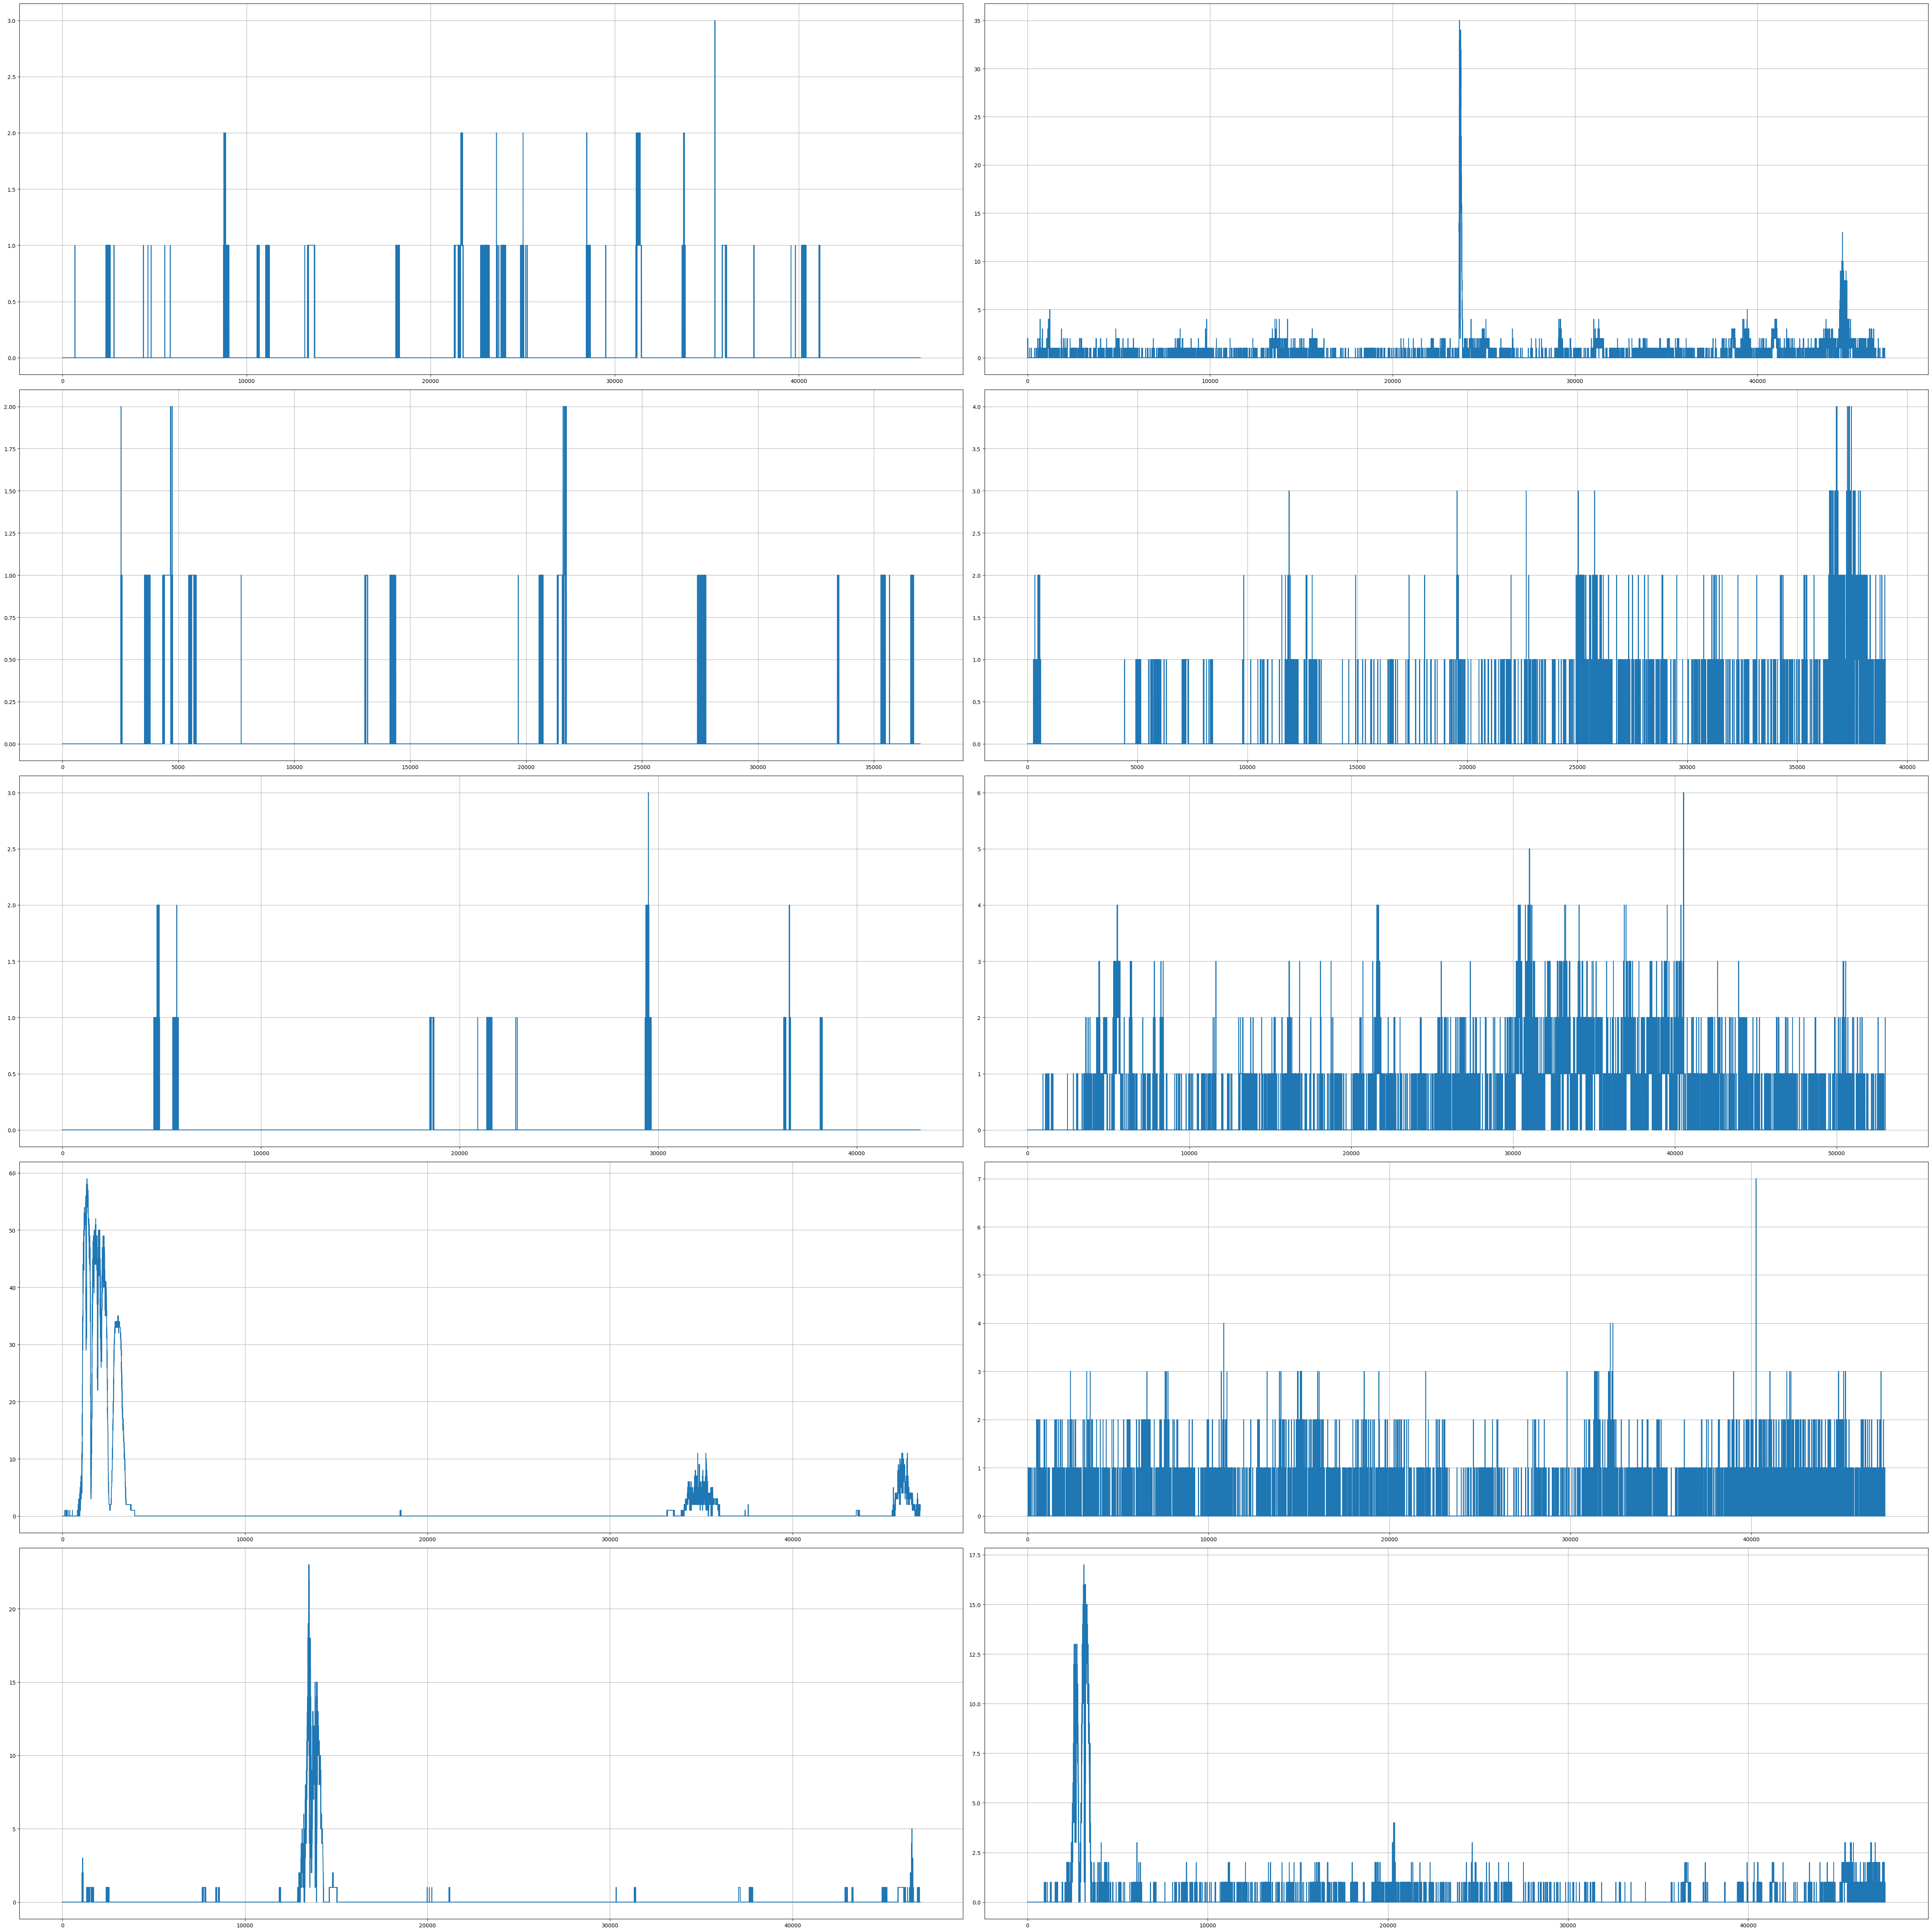

In [65]:
fig, ax = plt.subplots(5, 2, figsize=(50, 50))

s0 = 0
s1 = 0
l0_percs = []
l1_percs = []
for i in range(5):
    # 0
    path = '/kaggle/input/seed-1-tr/seed_iv/val/0/' + str(i) + '.npy'
    length = np.load(path).T.shape[0]
    
    
    
    cur_an = (loss0[s0:s0 + length] > ths).sum(axis=1)
    l0_percs.append((cur_an == 0).sum() / length)
    
    ax[i][0].plot(cur_an)
#     ax[i][0].plot([0, length - 1], [ths[0], ths[0]])
    ax[i][0].grid()
    
    s0 += length
    
    # 1
    path = '/kaggle/input/seed-1-tr/seed_iv/val/1/' + str(i) + '.npy'
    length = np.load(path).T.shape[0]
    
    
    cur_an = (loss1[s1:s1 + length] > ths).sum(axis=1)
    l1_percs.append((cur_an == 0).sum() / length)
    
    ax[i][1].plot(cur_an)
#     ax[i][1].plot(loss1[s1:s1 + length, 0])
#     ax[i][1].plot([0, length - 1], [ths[0], ths[0]])
    ax[i][1].grid()
    
    s1 += length

fig.tight_layout()
fig.show()

In [66]:
an0 = (loss0 > ths).sum(axis=1)
percent_of_anomalys0 = (an0 == 0).sum() / an0.shape[0]

an1 = (loss1 > ths).sum(axis=1)
percent_of_anomalys1 = (an1 == 0).sum() / an1.shape[0]

percent_of_anomalys0, percent_of_anomalys1

(0.9317316183963226, 0.8688190423281554)

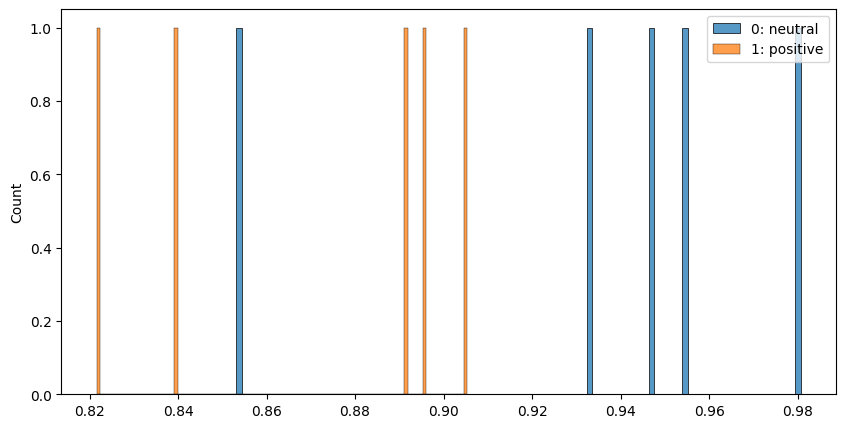

In [67]:
plt.figure(figsize=(10, 5))
sns.histplot(l0_percs, label='0: neutral', bins=100)
sns.histplot(l1_percs, label='1: positive', bins=100)
plt.legend()
plt.show()

## Ссылки: 
- https://www.youtube.com/watch?v=b2fSzneXPsg
- https://github.com/imperial-qore/TranAD/tree/main/src
- затерянный в таиланде фильм 